# Caffeine Side Learning Y-maze

## Load packages

In [4]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(emmeans) # Post-hoc analysis on the model
require(DHARMa) # Evaluate model fit
require(AICcmodavg) # For model selection and averaging

Loading required package: reshape2

Loading required package: lme4

Loading required package: Matrix

Loading required package: emmeans

Loading required package: DHARMa

This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: AICcmodavg


Attaching package: ‘AICcmodavg’


The following object is masked from ‘package:lme4’:

    checkConv




## Clean-up

In [6]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

## Load data

In [7]:
ELP = read.csv("./Data/All/ELP_all.csv")
ELP = subset(ELP, ELP$Experiment == "1") # Subset for Dopamine experiment
head(ELP, n = 1) # Check it was loaded correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full,Experiment,Initial_Binary,Final_Binary,Switched_Binary,TSM_Bin
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
1,18.03.22,09:45,Stefanie Kau,24.3,26th January - Spain,4-days,35,36,1,2,⋯,20,592,10.5,NA,No,1,0,0,0,0-30


## Ensure relevant variables are factors

In [8]:
ELP$Collection_Date = as.factor(ELP$Collection_Date)
ELP$Experimentor = as.factor(ELP$Experimentor)
ELP$Starvation_Period = as.factor(ELP$Starvation_Period)
ELP$Colony_ID = as.factor(paste0(ELP$Donor_Colony, "_", ELP$Recipient_Colony))
ELP$Ant_ID = as.factor(ELP$Ant_ID)

ELP$Visit = as.factor(ELP$Visit)
ELP$Solution = as.factor(ELP$Solution)
ELP$Solution = relevel(ELP$Solution, "Control")
ELP$Reward_Side = as.factor(ELP$Reward_Side)
ELP$TSM_Bin = as.factor(ELP$TSM_Bin)

ELP$Initial_Binary = as.factor(ELP$Initial_Binary)
ELP$Final_Binary = as.factor(ELP$Final_Binary)

## Identify relevant random effects

In [9]:
unique(ELP$Collection_Date)
unique(ELP$Experimentor)
unique(ELP$Starvation_Period)
unique(ELP$Colony_ID)
unique(ELP$Ant_ID)

[1] 18.03.22 21.03.22 22.03.22 23.03.22 24.03.22 25.03.22 28.03.22 29.03.22
 [9] 30.03.22 31.03.22
10 Levels: 18.03.22 21.03.22 22.03.22 23.03.22 24.03.22 25.03.22 ... 31.03.22

[1] Stefanie Kau            Stefanie Kau + Henrique Laura Neubauer         
Levels: Laura Neubauer Stefanie Kau Stefanie Kau + Henrique

[1] 4-days 5-days
Levels: 4-days 5-days

[1] 35_36 32_29 37_38 2_7   32_7  16_13 9_11 
Levels: 16_13 2_7 32_29 32_7 35_36 37_38 9_11

[1] 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
[76] 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
97 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 97

## Do initial and final choices significantly differ?

In [10]:
ELP_choice_diff = melt(ELP, measure.vars = c("Initial_Binary", "Final_Binary"))

ELP_choice_diff$variable = as.factor(ELP_choice_diff$variable)
ELP_choice_diff$value = as.factor(ELP_choice_diff$value)

ELP_choice_diff_mod = glmer(value ~ variable + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP_choice_diff, family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

e = emmeans(ELP_choice_diff_mod, ~variable, type = "response")
pairs(e)

boundary (singular) fit: see help('isSingular')



 contrast                      odds.ratio    SE  df null z.ratio p.value
 Initial_Binary / Final_Binary      0.875 0.149 Inf    1  -0.787  0.4313

Tests are performed on the log odds ratio scale 

p-value > 0.1 hence there is no statistical difference between initial and final decision therefore we will use final decision henceforth.

## Define models

### 1. Null model
**Biological hypothesis:** Ants randomly choose a Y-maze arm.

In [11]:
null_mod = glmer(Final_Binary ~ 1 + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 2. Visit model
**Biological hypothesis:** Ants learn to associate a Y-maze arm with a reward. Over consecutive visits more ants choose the correct arm.

In [12]:
visit_mod = glmer(Final_Binary ~ Visit + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 3. Solution model
**Biological hypothesis:** The presence of a psychoactive chemical in the reward alters the ants ability to choose a Y-maze arm.

In [13]:
solution_mod = glmer(Final_Binary ~ Solution + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 4. Side model
**Biological hypothesis:** Ants have an intrinsic predisposition towards turning left or right. This is associated with brain lateralisation which has been shown in multiple organisms.

In [14]:
side_mod = glmer(Final_Binary ~ Reward_Side + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 5. Time since marking model
**Biological hypothesis:** Ants that had a waiting period (>30 minutes) after learning the reward/side association have different recall strenght. This should be associated with long-term memory formation which should be stronger.

In [15]:
tsm_mod = glmer(Final_Binary ~ TSM_Bin + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 6. Solution and Visit with Time since marking model
**Biological hypothesis:** The effects of a psychoactive chemical might be time dependent.

In [16]:
solution_time_mod = glmer(Final_Binary ~ Solution + TSM_Bin + Visit + Solution:TSM_Bin + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 7. Maximal model
**Biological hypothesis:** All of the available variables contribute towards ant learning.

In [17]:
max_mod = glmer(Final_Binary ~ Solution + Visit + TSM_Bin + Reward_Side + Solution:TSM_Bin + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



## Model Selection

In [18]:
cand_models = list("null_mod" = null_mod, 
                   "visit_mod" = visit_mod,
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "tsm_mod" = tsm_mod,
                   "solution_time_mod" = solution_time_mod,
                   "max_mod" = max_mod)

aictab(cand_models)
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,side_mod,8,501.8878,0.000000,1.000000000,0.638225218,-242.7539,0.6382252
1,null_mod,7,504.4206,2.532764,0.281849579,0.179883509,-245.0629,0.8181087
3,solution_mod,8,506.1806,4.292781,0.116905385,0.074611965,-244.9003,0.8927207
2,visit_mod,10,506.9406,5.052734,0.079948959,0.051025442,-243.1785,0.9437461
5,tsm_mod,11,507.0194,5.131539,0.076860031,0.049054010,-242.1586,0.9928001
7,max_mod,20,511.2428,9.354942,0.009302512,0.005937098,-234.4770,0.9987372
6,solution_time_mod,19,514.3386,12.450787,0.001978545,0.001262757,-237.1367,1.0000000


,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,side_mod,8,501.8878,0.000000,1.00000000,0.63822522,-242.7539,0.6382252
1,null_mod,7,504.4206,2.532764,0.28184958,0.17988351,-245.0629,0.8181087
3,solution_mod,8,506.1806,4.292781,0.11690539,0.07461197,-244.9003,0.8927207
2,visit_mod,10,506.9406,5.052734,0.07994896,0.05102544,-243.1785,0.9437461
5,tsm_mod,11,507.0194,5.131539,0.07686003,0.04905401,-242.1586,0.9928001


**The side_mod explains 64% of the total variance explained by all of the models tested.**

In [19]:
evidence(aic.table = aictab(cand_models))

Evidence ratio between models 'side_mod' and 'null_mod':
3.55

The side model is 4 times more parsimonious than the next "best" model (null_mod).

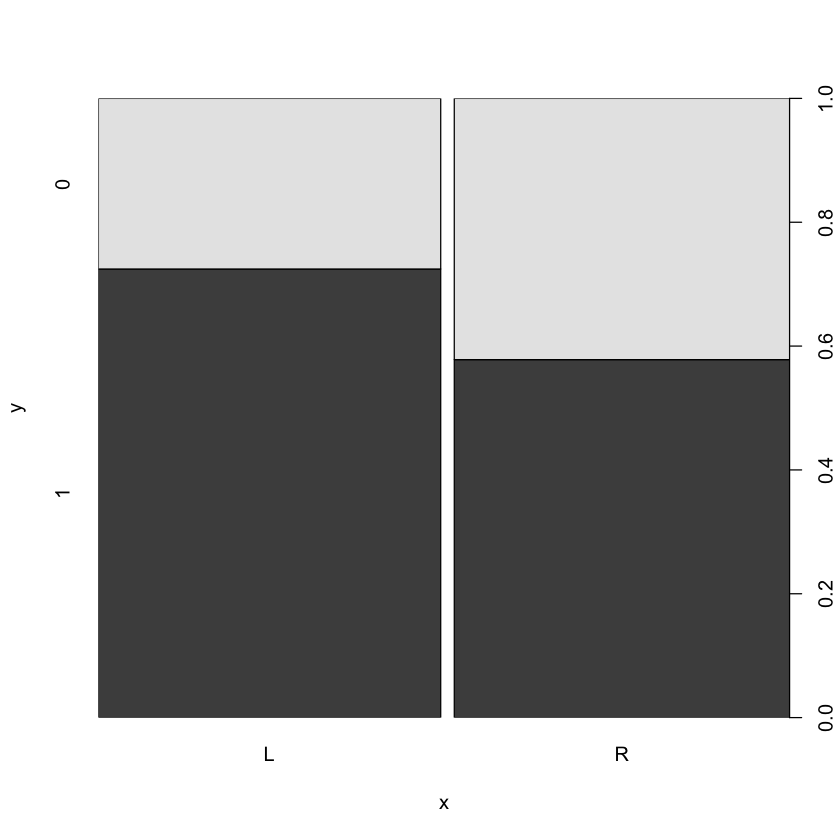

In [20]:
plot(ELP$Reward_Side, ELP$Final_Binary)

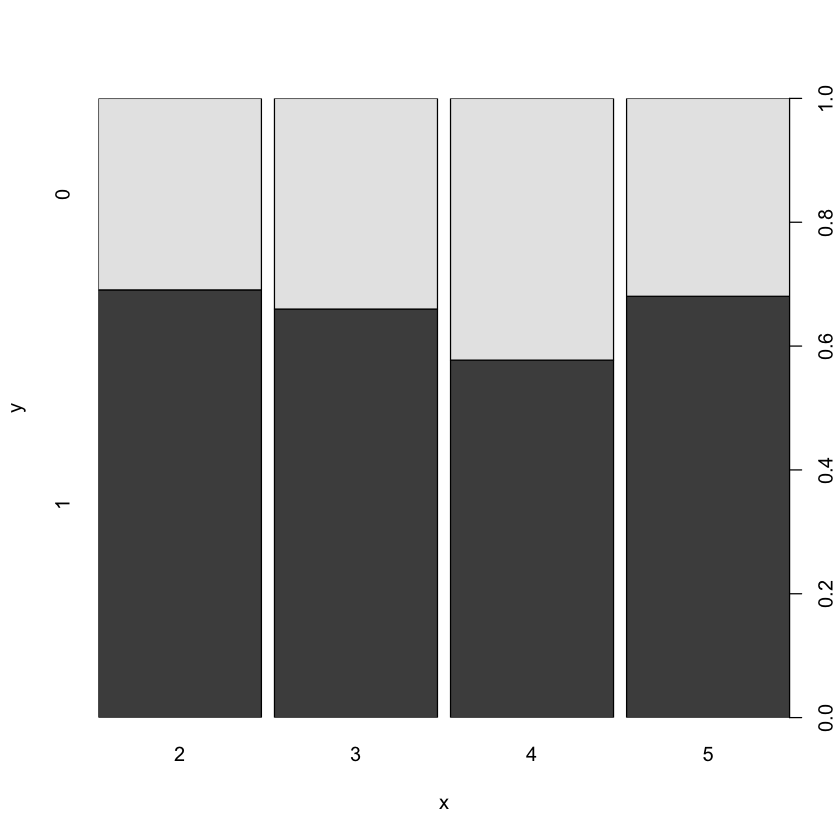

In [21]:
plot(ELP$Visit, ELP$Final_Binary)

## Initial Conclusions
- Visit seems to not have an effect on choice.
- There seems to be a very slight side bias towards the Left.

## Brain lateralisation VS Visual Cues
**Stefanie setup had the wall on the Left!**
**Laura setup had the wall on the Right!**

## Model averaging

In [22]:
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,side_mod,8,501.8878,0.000000,1.00000000,0.63822522,-242.7539,0.6382252
1,null_mod,7,504.4206,2.532764,0.28184958,0.17988351,-245.0629,0.8181087
3,solution_mod,8,506.1806,4.292781,0.11690539,0.07461197,-244.9003,0.8927207
2,visit_mod,10,506.9406,5.052734,0.07994896,0.05102544,-243.1785,0.9437461
5,tsm_mod,11,507.0194,5.131539,0.07686003,0.04905401,-242.1586,0.9928001


There is no clearly better model!

In [27]:
top_models = list("side_mod" = side_mod, 
                   "null_mod" = null_mod,
                   "solution_mod" = solution_mod,
                   "visit_mod" = visit_mod,
                   "tsm_mod" = tsm_mod)

modavgShrink(top_models, parm = "(Intercept)")
modavgShrink(top_models, parm = "SolutionCaffeine")
modavgShrink(top_models, parm = "Visit3")
modavgShrink(top_models, parm = "Visit4")
modavgShrink(top_models, parm = "Visit5")
modavgShrink(top_models, parm = "TSM_Bin31-60")
modavgShrink(top_models, parm = "TSM_Bin61-90")
modavgShrink(top_models, parm = "TSM_Bin91-120")
modavgShrink(top_models, parm = "TSM_Bin121+")
modavgShrink(top_models, parm = "Reward_SideR")

Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,1.0173266,0.2126609
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.7569021,0.1841682
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.6742887,0.2327368
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,0.9591086,0.2770274
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,0.4650766,0.2335113


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,0.0000000,0.0000000
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.0000000,0.0000000
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.1574009,0.2757442
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,0.0000000,0.0000000
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,0.0000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,0.0000000,0.0000000
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.0000000,0.0000000
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.0000000,0.0000000
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,-0.1584059,0.3237719
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,0.0000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,0.0000000,0.0000000
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.0000000,0.0000000
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.0000000,0.0000000
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,-0.5551231,0.3196563
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,0.0000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,0.00000000,0.0000000
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.00000000,0.0000000
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.00000000,0.0000000
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,-0.05358952,0.3258917
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,0.00000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,0.00000000,0.0000000
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.00000000,0.0000000
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.00000000,0.0000000
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,0.00000000,0.0000000
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,-0.04023084,0.3742851


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,0.0000000,0.0000000
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.0000000,0.0000000
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.0000000,0.0000000
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,0.0000000,0.0000000
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,0.8361697,0.4204121


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,0.000000,0.0000000
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.000000,0.0000000
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.000000,0.0000000
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,0.000000,0.0000000
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,0.446929,0.3817399


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,0.0000000,0.0000000
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.0000000,0.0000000
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.0000000,0.0000000
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,0.0000000,0.0000000
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,0.4436825,0.3849684


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
side_mod,8,501.8878,0.000000,1.00000000,0.64285367,-242.7539,-0.5910197,0.2743583
null_mod,7,504.4206,2.532764,0.28184958,0.18118804,-245.0629,0.0000000,0.0000000
solution_mod,8,506.1806,4.292781,0.11690539,0.07515306,-244.9003,0.0000000,0.0000000
visit_mod,10,506.9406,5.052734,0.07994896,0.05139548,-243.1785,0.0000000,0.0000000
tsm_mod,11,507.0194,5.131539,0.07686003,0.04940975,-242.1586,0.0000000,0.0000000


## Odds
**If the odds is 1 there is no effect, therefore if the CI's cross 1 that is not a significant parameter**

**Intercept** = 2.5 [1.5, 4.2] -> **Ants do not choose an arm of the Y-maze randomly at Visit 2!**

**Solution** = 1.0 [0.9, 1.2] -> There is no effect of Solution!

**Visit 3** = 1.0 [0.8, 1.2] -> There is no effect of Visit 3!

**Visit 4** = 1.0 [0.7, 1.3] -> There is no effect of Visit 4!

**Visit 5** = 1.0 [0.9, 1.2] -> There is no effect of Visit 5!

**Side** = 0.7 [0.3, 1.4] -> There is no effect of Side!

**TSM_31_60** = 1.0 [0.8, 1.2] -> There is no effect of Time Since Marking!

**TSM_61_90** = 1.0 [0.7, 1.6] -> There is no effect of Time Since Marking!

**TSM_91_120** = 1.0 [0.8, 1.3] -> There is no effect of Time Since Marking!

**TSM_121+** = 1.0 [0.8, 1.3] -> There is no effect of Time Since Marking!

## Conclusions
- Ants do not choose a random side of the Y-maze from Visit 2 showing no change in the odds over consecutive visits suggesting the ants are able to associate the reward with a side.
- There is no effect of Time Since Marking on final choice.
- There is no efect of caffeine on final choice.
- There is no statistically significant (yes in side_mod) side bias although there is a trend towards Left.
- There is no interaction effect of Solution with Time Since Marking.